In [30]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
# Read and get information about Data
customer_data = pd.read_csv('Data.csv')

In [3]:
customer_data.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [5]:
print('Data rows and Columns:',customer_data.shape)

Data rows and Columns: (4459, 4993)


* The tagert value Y named 'Target' in the second Column, other Feature name doesn't mean anything for now

* Most of colums are full of zero from current perspective, it may can be femoved in futher processing

* Original Data has 4459 Data points and 4993 features, it may need operation for dimention reduction

# Checking Missing Values

In [6]:
def is_missing(data):
    missing_num =  data.columns[data.isnull().sum() != 0].size
    if missing_num != 0:
        missing_col = list(data.columns[data.isnull().sum() != 0])
        return missing_col
    else:
        print('There is no missing value in this Dataset')

is_missing(customer_data)

There is no missing value in this Dataset


# Remove Constant Columns From Data

In [7]:
def remove_constant(data):
    col_to_remove = []
    for col in data.columns:
        if col != 'ID' and col != 'target':
            if data[col].std() == 0:
                col_to_remove.append(col)
    return col_to_remove

In [8]:
remove_constant_col = remove_constant(customer_data)
customer_data.drop(remove_constant_col, axis = 1, inplace = True)  # Remove Constant Columns
print(remove_constant_col)
print('The number of column removed:',len(remove_constant_col))

['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a742107', '08b9ec4ae', 'd95203ded'

* There are 256 columns having constant values has been removed

# Remove Duplicated Columns

In [9]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups    
    # Covert data to dict like structure for better manipulate
    dups = []

    for t, v in groups.items(): 

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):            
        # Search dupilicated columns column by column
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break

    return dups   # Return duplicated columns

# Referance: https://www.kaggle.com/code/samratp/lightgbm-xgboost-catboost#XGB-Modeling

In [10]:
remove_duplicate_col = duplicate_columns(customer_data)
print('Duplicated columns are:',remove_duplicate_col)

Duplicated columns are: ['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']


In [11]:
customer_data.drop(remove_duplicate_col, axis = 1, inplace = True)

   When we say sparce data, it always refers to the columns in dataset which has many gaps present data being recorded,
i.e., most or all of them are zero. Althogh these data are functioning properly and valid but the actual reading is zero, which means these feature has no effect to result at all.  
   For example, if one feature in our data has bool value, and the probility for this to be true is only 0.01%, hence
produce sparce data.

## Handle Sparce Data

In [12]:
def drop_saprce(data):
    column_to_detect = [col for col in data.columns if col not in['ID','target']]
    counter = 0
    for col in column_to_detect:
        if len(np.unique(data[col])) < 2:
            data.drop(col, axis = 1, inplace = True)
            counter += 1
    print('The number of column has been droped is:', counter)
    return data

In [13]:
customer_data = drop_saprce(customer_data)

The number of column has been droped is: 0


# Split Train and Test Data

In [14]:
customer_data_X = customer_data.drop(['ID', 'target'], axis=1)
customer_data_Y = customer_data['target']

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(customer_data_X, customer_data_Y, test_size = 0.2, random_state = 42)

8398890.173264287


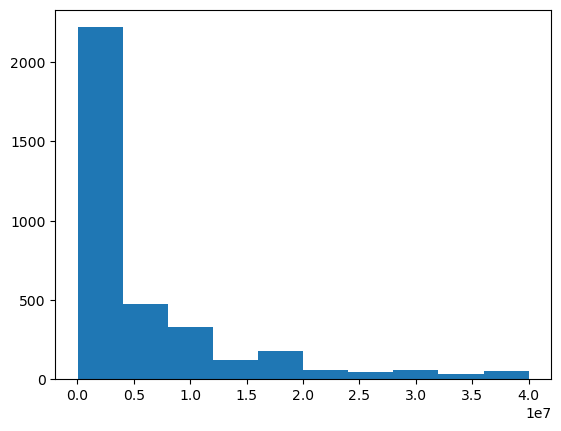

In [16]:
#See the distrubution of Y if it needs futher process
plt.hist(Y_train)
print(Y_train.std())

* The distrubution of Y has high variance and does not obbey normal distribution, it's left skewed and inbalanced, it's need further process

1.7643566208398558


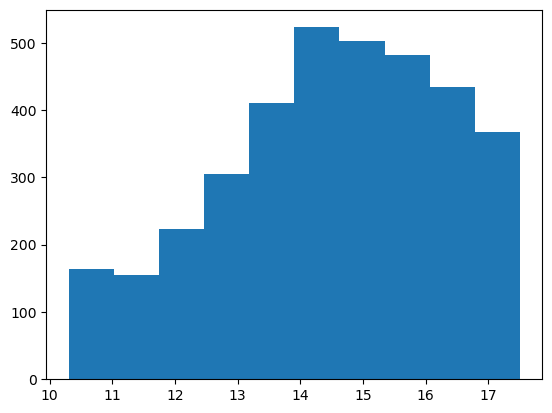

In [17]:
plt.hist(np.log1p(Y_train))
print(np.log1p(Y_train).std())

In [18]:
Y_train = np.log1p(Y_train)

* After take log for the Y value, the variance of the Y distibution gets much lower wihle it also more like a noraml distribution now
* Here we using log1p rather than log for higer accuracy

# Regression: Predict the Customer's Transaction Value

## Baseline System 1: Trival System

In [21]:
def Make_Score_Reg(Test_Y,Pred_Y):
    res_ = {}
    res_['RMSLE'] = mean_squared_log_error(Test_Y,Pred_Y)
    res_['R2'] = r2_score(Test_Y,Pred_Y)
    return res_

In [36]:
def Trival_System(Train_Y,Test_Y)-> dict:
    mean = np.mean(Train_Y)
    Pred_Y = [mean]*len(Test_Y)
    Pred_Y = np.expm1(Pred_Y)
    return Make_Score_Reg(Test_Y,Pred_Y)

## Baseline System 2: KNN Regression (Parameters = Default)

In [37]:
def KNN_Regression(Train_X,Train_Y,Test_X,Test_Y)-> dict:
    KNN_modle = KNeighborsRegressor()
    Pred_Y = KNN_modle.fit(Train_X,Train_Y).predict(Test_X)
    Pred_Y = np.expm1(Pred_Y)
    return Make_Score_Reg(Test_Y,Pred_Y)

## Random Forest Regressor

In [43]:
def Random_Froest_Regressor(Train_X,Train_Y,Test_X,Test_Y):
    # Set parameters for cross validation
    parm_grid_RF = {'n_estimators':[50,100,150],
                    'criterion':['squared_error'],
                    'max_depth':[3,5,None]}
    Kfold = KFold(n_splits=5,shuffle=True, random_state=42)
    score_RF = {'RMSLE':make_scorer(mean_squared_log_error),
                'R2':make_scorer(r2_score)}
    RF_grid = GridSearchCV(RandomForestRegressor(),param_grid = parm_grid_RF,cv = Kfold,
                           scoring = score_RF, refit = 'RMSLE')
    # Train and Evaluate Model
    RF_grid.fit(Train_X, Train_Y)
    Best_RF = RF_grid.best_estimator_
    Best_RF.fit(Train_X, Train_Y)
    Pred_Y = Best_RF.predict(Test_X)
    Pred_Y = np.expm1(Pred_Y)
    return Make_Score_Reg(Test_Y,Pred_Y)

In [24]:
Perf_RF = Random_Froest_Regressor(X_train,Y_train,X_test,Y_test)

In [25]:
Perf_RF

{'RMSLE': 2.0307049653716174, 'R2': 0.11666046802927255}

## AdaBoost Regressor

In [42]:
def AdaBoost_Regressor(Train_X,Train_Y,Test_X,Test_Y):
    Ada_Parm_grid = {'n_estimators':[n for n in range(50,200,10)],
                     'learning_rate':[0.001,0.01,0.1,1],
                     'loss':['linear', 'square', 'exponential']}
    Kfold = KFold(n_splits=5,shuffle=True, random_state=42)
    score_Ada = {'RMSLE':make_scorer(mean_squared_log_error),
                'R2':make_scorer(r2_score)}
    Ada_grid = GridSearchCV(AdaBoostRegressor(),param_grid = Ada_Parm_grid,cv = Kfold,
                           scoring = score_Ada, refit = 'RMSLE')
    Ada_grid.fit(Train_X, Train_Y)
    Best_Ada = Ada_grid.best_estimator_
    print('Best Parameters for AdaBoost is:',Ada_grid.best_params_)
    Best_Ada.fit(Train_X, Train_Y)
    Pred_Y = Best_Ada.predict(Test_X)
    Pred_Y = np.expm1(Pred_Y)
    return Make_Score_Reg(Test_Y,Pred_Y)

In [27]:
Perf_Ada = AdaBoost_Regressor(X_train,Y_train,X_test,Y_test)
Perf_Ada

{'RMSLE': 2.7990357073543515, 'R2': -0.2859751463033029}

## XGBoost Regressor

In [44]:
def XGBoost_Para(Train_X,Train_Y):
    XGB_para = {'learning_rate':[0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
                'min_child_weight' : [ 1, 3, 5, 7 ],
                'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]}
    XGB_model = xgb.XGBRegressor(objective = 'reg:squarederror')
    score_XGB = {'RMSLE':make_scorer(mean_squared_log_error),
                'R2':make_scorer(r2_score)}
    XGB_CV = GridSearchCV(XGB_model, param_grid = XGB_para, cv = 5,
                        scoring = score_XGB, refit = 'RMSLE' )
    XGB_CV.fit(Train_X, Train_Y)
    return XGB_CV.best_params_

In [ ]:
XGB_para = XGBoost_Para(X_train,Y_train)
XGB_para

In [28]:
def XGB_Train(Train_X,Train_Y,Test_X,Test_Y):
    XGB_Train_Data = xgb.DMatrix(Train_X,Train_Y)
    XGB_Test_Data =  xgb.DMatrix(Test_X)
    para = {'objective': 'reg:squarederror',
            'eval_metric':'rmse',
            'max_depth': 15,
            'learning_rate': 0.3,
            'alpha':0.001,
            'gamma': 0.0,
            'eta': 0.001,
            'min_child_weight': 1}
    model_XGB = xgb.train(para, XGB_Train_Data, 50, maximize=False, verbose_eval=100)
    Pred_Y = np.expm1(model_XGB.predict(XGB_Test_Data))
    return Make_Score_Reg(Test_Y,Pred_Y)

In [31]:
Perf_XGB = XGB_Train(X_train,Y_train,X_test,Y_test)
Perf_XGB

{'RMSLE': 2.3146692669050632, 'R2': 0.03518023119284752}

## Light GBM Regressor

In [190]:
def LGBM_Para(Train_X, Train_Y):
    Model = lgb.LGBMRegressor(objective = 'regression',silent = True)
    LGB_paras = {'learning_rate': [0.001, 0.01, 0.1],
                 'num_leaves': [50, 80, 100, 120],
                 'feature_fraction': [0.1, 0.6, 0.8, 0.9],
                 'bagging_fraction': [0.6, 0.8, 1],
                 'max_depth': [5,15,30],
                 'subsample': [0.01, 0.1, 1.0]}
    score_LGBM = {'RMSLE':make_scorer(mean_squared_log_error),
                'R2':make_scorer(r2_score)}
    LGBM_Grid = GridSearchCV(estimator = Model, param_grid = LGB_paras, cv = 5,scoring = score_LGBM, refit = 'RMSLE')
    LGBM_Grid.fit(Train_X, Train_Y)
    return LGBM_Grid.best_params_    

In [97]:
LGB_Para = LGBM_Para(X_train, Y_train)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.01 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.01 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.01 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.1 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_frac

In [192]:
LGB_Para

{'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'learning_rate': 0.1,
 'max_depth': 15,
 'num_leaves': 50,
 'subsample': 0.01}

In [61]:
def LGBM_Train(Train_X,Train_Y,Test_X,Test_Y):
    LGBM_para = {'objective' : 'regression',
                 'metric':'rmse',
                 'bagging_fraction': 0.6,
                 'feature_fraction': 0.6,
                 'learning_rate': 0.1,
                 'max_depth': 15,
                 'num_leaves': 50,
                 'force_row_wise':True,
                 'verbose': -1}
    LGBM_Train_Data = lgb.Dataset(Train_X, label = Train_Y, silent = True, params={'verbose': -1}, free_raw_data=False)
    LGBM_Model = lgb.train(params = LGBM_para, train_set = LGBM_Train_Data,)
    Pred_Y = np.expm1(LGBM_Model.predict(Test_X))
    return Make_Score_Reg(Test_Y,Pred_Y)

In [62]:
Perf_LGBM = LGBM_Train(X_train,Y_train,X_test,Y_test)

In [63]:
Perf_LGBM

{'RMSLE': 2.058711840806955, 'R2': 0.15099904947174136}

# Performance Evaluation

## Baseline systems

In [39]:
Perf_Trival = Trival_System(Y_train,Y_test)
Perf_KNN = KNN_Regression(X_train,Y_train,X_test,Y_test)

Create a DataFrame to store Performance of each algorithms

In [40]:
System_Performance = {'Algorithm':['Trival','KNN','Random Forest',
                                   'AdaBoost','XGBoost', 'LightGBM'],
                      'RMSLE':[Perf_Trival['RMSLE'], Perf_KNN['RMSLE'], Perf_RF['RMSLE'],
                               Perf_Ada['RMSLE'], Perf_XGB['RMSLE'], Perf_LGBM['RMSLE']],
                      'R2':[Perf_Trival['R2'], Perf_KNN['R2'], Perf_RF['R2'],
                               Perf_Ada['R2'], Perf_XGB['R2'], Perf_LGBM['R2']]}
System_Performance = pd.DataFrame(System_Performance)

In [41]:
System_Performance

,Algorithm,RMSLE,R2
0,Trival,2.877364,-0.232779
1,KNN,3.269846,-0.149841
2,Random Forest,2.030705,0.116660
3,AdaBoost,2.799036,-0.285975
4,XGBoost,2.314669,0.035180
5,LightGBM,2.058712,0.150999


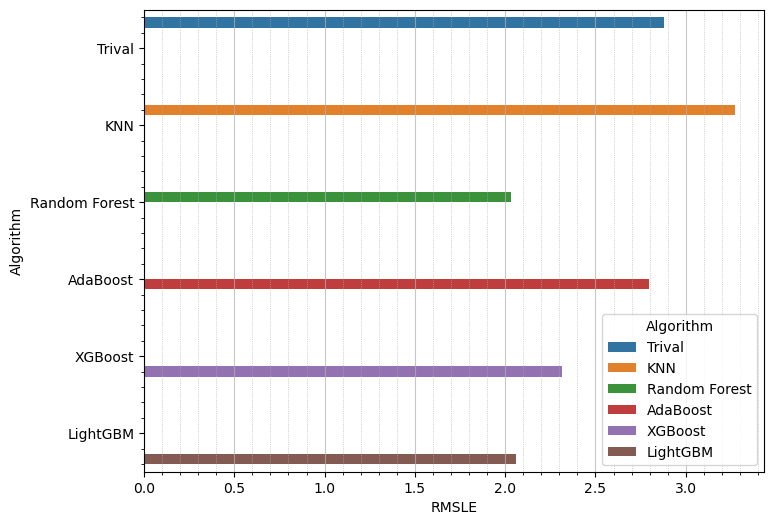

In [42]:
plt.figure(figsize=(8,6))
ax_RMSLE = sns.barplot(x = 'RMSLE',y = 'Algorithm', data = System_Performance, hue = 'Algorithm')
ax_RMSLE.grid(which = 'major', axis = 'x', alpha = 0.7)
ax_RMSLE.grid(which = 'minor', axis = 'x', linestyle=':', linewidth=0.5)
ax_RMSLE.minorticks_on()

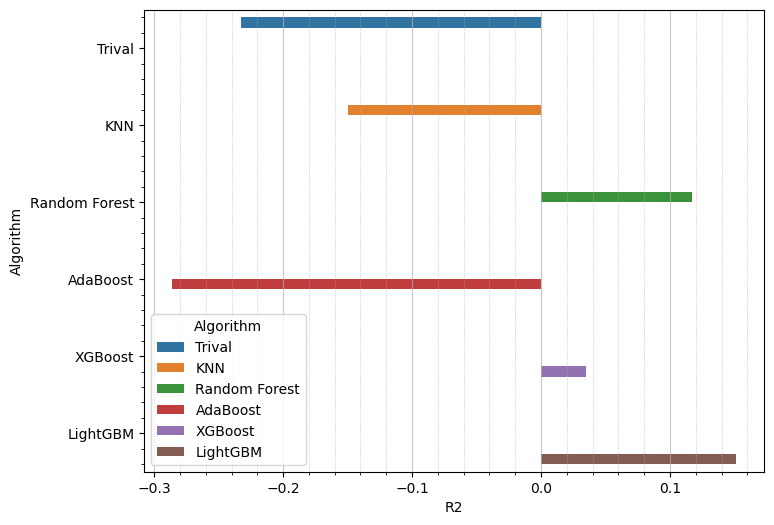

In [43]:
plt.figure(figsize=(8,6))
ax_R2 = sns.barplot(x = 'R2',y = 'Algorithm', data = System_Performance, hue = 'Algorithm')
ax_R2.grid(which = 'major', axis = 'x', alpha = 0.7)
ax_R2.grid(which = 'minor', axis = 'x', linestyle=':', linewidth=0.5)
ax_R2.minorticks_on()